## Setup

In [419]:
import json
import os
import random

import sklearn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

# from sklearn.metrics import confusion_matrix

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

# Load the data

We will use the SMD data sets for training and testing.

You can find raw data in https://github.com/NetManAIOps/OmniAnomaly/tree/master/ServerMachineDataset

I preprocessed this dataset which consist of 28 entities and 38 dimensions


In [420]:
train_url = "./datasets/SMD/train/"
test_url = "./datasets/SMD/test/"
machine_label = {1: 8, 2: 9, 3: 11}
train_data = []
test_data = []
for i, nums in machine_label.items():
    train = []
    test = []
    for j in range(1, nums + 1):
        file_name = f"machine-{i}-{j}.csv"
        df_train = pd.read_csv(
            os.path.join(train_url, file_name), parse_dates=True, index_col="timestamp"
        )
        df_test = pd.read_csv(
            os.path.join(test_url, file_name), parse_dates=True, index_col="timestamp"
        )
        train.append(df_train)
        test.append(df_test)
    train_data.append(train)
    test_data.append(test)

## Quick look at the data

In [421]:
machine, idx = 1, 1

print(train_data[machine][idx].head())

           feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
timestamp                                                                     
0                0.0   0.000510   0.001152   0.002355        0.0   0.609359   
1                0.0   0.000595   0.001152   0.002355        0.0   0.610183   
2                0.0   0.001445   0.001152   0.002355        0.0   0.611626   
3                0.0   0.001020   0.001152   0.002355        0.0   0.612451   
4                0.0   0.000340   0.000864   0.002018        0.0   0.613069   

           feature_7  feature_8  feature_9  feature_10  ...  feature_30  \
timestamp                                               ...               
0           0.046951        0.0   0.043478    0.003788  ...        0.25   
1           0.048030        0.0   0.326087    0.000000  ...        0.25   
2           0.049649        0.0   0.000000    0.000000  ...        0.25   
3           0.051268        0.0   0.000000    0.000000  ...        0.25

## Visualize the data
### Timeseries data without anomalies

We will use the following data for training.

/tmp/ipykernel_49765/1574097951.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  train_data[machine][idx].plot(legend=False, ax=ax, subplots=True, layout=(10, 4), sharex=True)


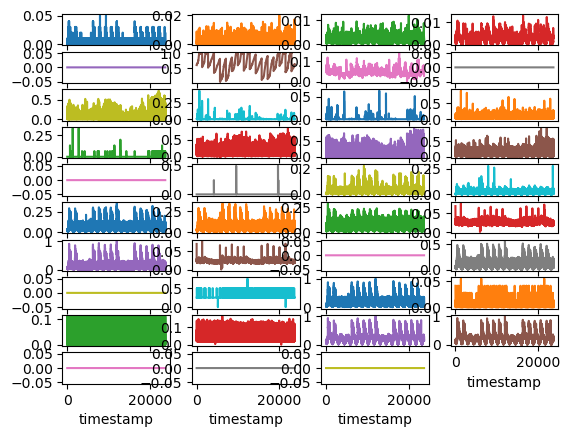

In [438]:
fig, ax = plt.subplots()
train_data[machine][idx].plot(legend=False, ax=ax, subplots=True, layout=(10, 4), sharex=True)
plt.show()

### Timeseries data with anomalies

We will use the following data for testing and see if the sudden jump up in the
data is detected as an anomaly.

/tmp/ipykernel_49765/1364411638.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  test_data[machine][idx].plot(legend=False, ax=ax, subplots=True, layout=(10, 4), sharex=True)


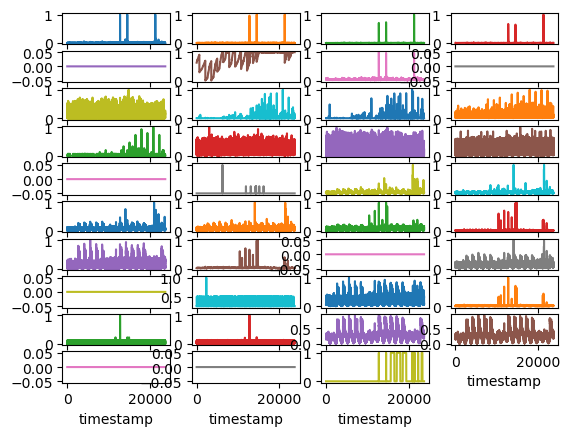

In [423]:
fig, ax = plt.subplots()
test_data[machine][idx].plot(legend=False, ax=ax, subplots=True, layout=(10, 4), sharex=True)
plt.show()

## Prepare training data


In [424]:
# Normalize and save the mean and std we get,
# for normalizing test data.
# Since model is too simple, so we will use only few featrues for learning.
num_of_features = 1
data_for_train = train_data[machine][idx].fillna(method='ffill').iloc[:, :num_of_features]

print(data_for_train.head())
print(data_for_train.isnull().sum())

training_mean = data_for_train.mean()
training_std = data_for_train.std()
df_training_value = (data_for_train - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

           feature_1
timestamp           
0                0.0
1                0.0
2                0.0
3                0.0
4                0.0
feature_1    0
dtype: int64
Number of training samples: 23700


### Create sequences
Create sequences combining `TIME_STEPS` contiguous data values from the
training data.

In [425]:
# Increase TIME_STEPS: high recall, low precision
# Decrease TIME_STEPS: low recall, high precision
TIME_STEPS = 1500


# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (22201, 1500, 1)


## Build a model

We will build a convolutional reconstruction autoencoder model. The model will
take input of shape `(batch_size, sequence_length, num_features)` and return
output of the same shape. In this case, `sequence_length` is 288 and
`num_features` is 1.

In [426]:
model = keras.Sequential(
    [
        layers.InputLayer((x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
        layers.Dropout(rate=0.2),
        layers.Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=x_train.shape[2], kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_48 (Conv1D)           (None, 750, 32)           256       
_________________________________________________________________
dropout_48 (Dropout)         (None, 750, 32)           0         
_________________________________________________________________
conv1d_49 (Conv1D)           (None, 375, 16)           3600      
_________________________________________________________________
conv1d_transpose_72 (Conv1DT (None, 750, 16)           1808      
_________________________________________________________________
dropout_49 (Dropout)         (None, 750, 16)           0         
_________________________________________________________________
conv1d_transpose_73 (Conv1DT (None, 1500, 32)          3616      
_________________________________________________________________
conv1d_transpose_74 (Conv1DT (None, 1500, 1)         

## Train the model

Please note that we are using `x_train` as both the input and the target
since this is a reconstruction model.

In [427]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")],
)

Epoch 1/50
157/157 [==============================] - 2s 12ms/step - loss: 0.1953 - val_loss: 0.0601
Epoch 2/50
157/157 [==============================] - 2s 11ms/step - loss: 0.0473 - val_loss: 0.0174
Epoch 3/50
157/157 [==============================] - 2s 11ms/step - loss: 0.0274 - val_loss: 0.0213
Epoch 4/50
157/157 [==============================] - 2s 10ms/step - loss: 0.0210 - val_loss: 0.0319
Epoch 5/50
157/157 [==============================] - 2s 11ms/step - loss: 0.0176 - val_loss: 0.0319
Epoch 6/50
157/157 [==============================] - 2s 11ms/step - loss: 0.0154 - val_loss: 0.0373
Epoch 7/50
157/157 [==============================] - 2s 11ms/step - loss: 0.0137 - val_loss: 0.0423


Let's plot training and validation loss to see how the training went.

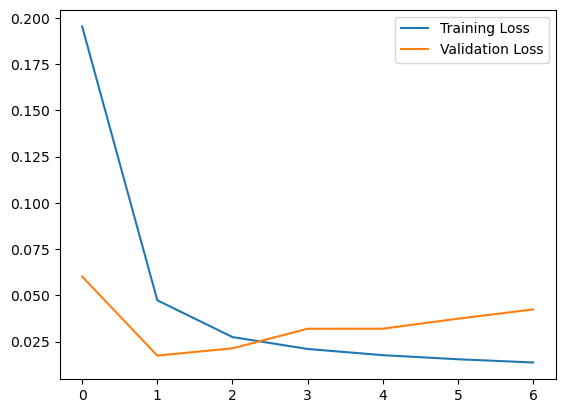

In [428]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

## Detecting anomalies

We will detect anomalies by determining how well our model can reconstruct
the input data.


1.   Find MAE loss on training samples.
2.   Find max MAE loss value. This is the worst our model has performed trying
to reconstruct a sample. We will make this the `threshold` for anomaly
detection.
3.   If the reconstruction loss for a sample is greater than this `threshold`
value then we can infer that the model is seeing a pattern that it isn't
familiar with. We will label this sample as an `anomaly`.


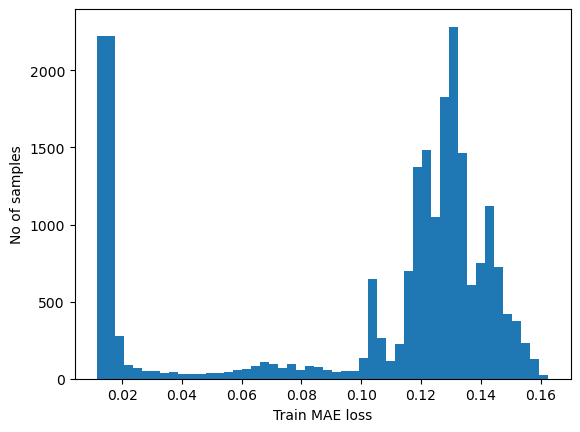

Reconstruction error threshold:  [0.16257283]


In [429]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss, axis=0)
print("Reconstruction error threshold: ", threshold)

### Compare recontruction

Just for fun, let's see how our model has recontructed the first sample.
This is the 288 timesteps from day 1 of our training dataset.

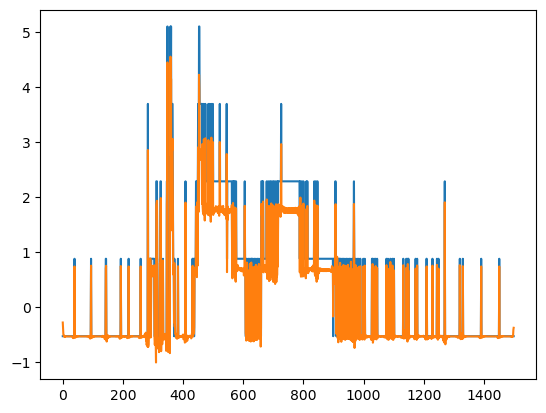

In [430]:
# Checking how the first sequence is learnt
for i in range(1, x_train.shape[2] + 1):
    ax = plt.subplot(x_train.shape[2], 1, i)
    plt.plot(x_train[0, :, i - 1])
    plt.plot(x_train_pred[0, :, i - 1])

plt.show()

### Prepare test data

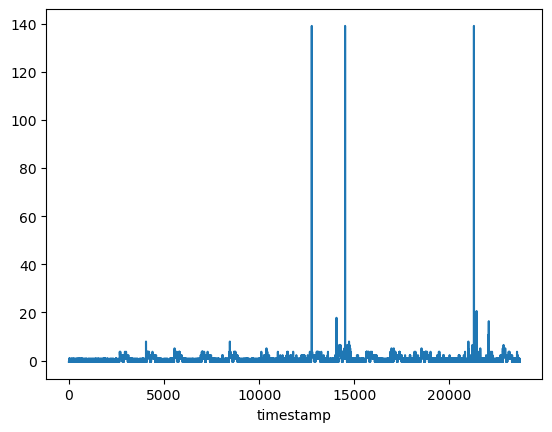

Test input shape:  (22201, 1500, 1)


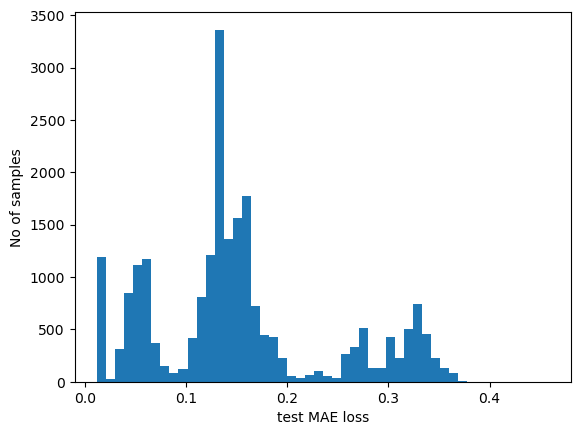

(22201, 1)
Number of anomaly samples:  6458
Indices of anomaly samples:  (array([11265, 11266, 11267, ..., 22197, 22199, 22200]),)


In [431]:
data_for_test = test_data[machine][idx].iloc[:, 0:num_of_features]

df_test_value = (data_for_test - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
# test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
print(test_mae_loss.shape)
anomalies = np.sum(test_mae_loss, axis=1) > np.sum(threshold)
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

## Plot anomalies

We now know the samples of the data which are anomalies. With this, we will
find the corresponding `timestamps` from the original test data. We will be
using the following method to do that:

Let's say time_steps = 3 and we have 10 training values. Our `x_train` will
look like this:

- 0, 1, 2
- 1, 2, 3
- 2, 3, 4
- 3, 4, 5
- 4, 5, 6
- 5, 6, 7
- 6, 7, 8
- 7, 8, 9

All except the initial and the final time_steps-1 data values, will appear in
`time_steps` number of samples. So, if we know that the samples
[(3, 4, 5), (4, 5, 6), (5, 6, 7)] are anomalies, we can say that the data point
5 is an anomaly.

In [432]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

Let's overlay the anomalies on the original test data plot.

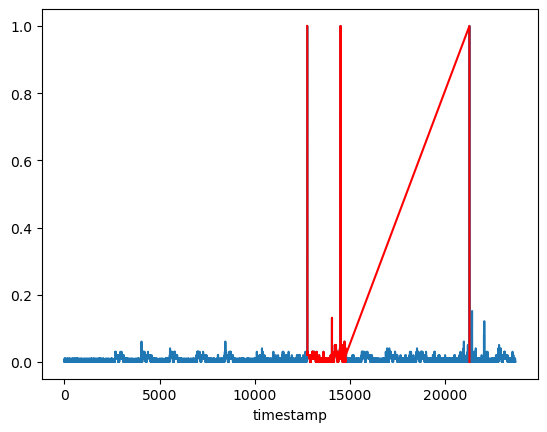

In [433]:
df_subset = test_data[machine][idx]["feature_1"].iloc[anomalous_data_indices]
fig, ax = plt.subplots()
test_data[machine][idx]["feature_1"].plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()

## Evaluate Results

We will calculate accuracy, recall and precision to evalutate our results

In [434]:
test_pred = np.zeros(len(test_data[machine][idx]))
test_label = test_data[machine][idx]["label"]
test_pred[anomalous_data_indices] = 1

accuracy = (np.sum(test_pred == test_label)) / len(test_label) * 100
precision = (np.sum(test_pred * test_label)) / np.sum(test_pred) * 100
recall = (np.sum(test_pred * test_label)) / np.sum(test_label) * 100

print(f"accuracy: {accuracy:.2f}%")
print(f"precision: {precision:.2f}%")
print(f"recall: {recall:.2f}%")

accuracy: 79.68%
precision: 1.13%
recall: 0.81%


In [435]:
from sklearn.metrics import classification_report
print(classification_report(test_label, test_pred))

              precision    recall  f1-score   support

           0       0.87      0.90      0.89     20867
           1       0.01      0.01      0.01      2833

    accuracy                           0.80     23700
   macro avg       0.44      0.46      0.45     23700
weighted avg       0.77      0.80      0.78     23700

